# ****============ CUSTOMER SEGMENTATION =============****

La empresa de Retail online OLIST necesita conocer más acerca de sus clientes. Está interesada, particularmente, en el comportamiento de los mismos en relación a las compras. El objetivo final es lograr dirigir más efectivamente sus acciones de marketing y comunicación, por lo cual le resulta interesante el poder agruparlas en relación a su comportamiento para consumo.

Con este objetivo en mente, le ha brindado sus datos y espera que usted le devuelva los grupos a los que pertenece cada usuario y la descripción de cada grupo. Le da plena libertad para seleccionar los datos a utilizar.

CONTEXTO

Este conjunto de datos es Olist, el mercado más grande de Brasil. Esta información se recopiló en el período 2016-2018. Olist conecta a pequeñas empresas de todo Brasil para ingresar a sus redes de manera muy sencilla simplemente mediante un contrato. Estos empresarios pueden vender sus productos a través de la plataforma Olist y enviarlos directamente a sus clientes con correos que han trabajado igual que Olist.

Después de que el cliente compre su producto a Olist, el vendedor recibirá una notificación para cumplir de inmediato con el pedido del cliente. Cuando un cliente recibe un producto, el cliente puede dar una calificación de satisfacción y comentarios relacionados con los servicios prestados por el vendedor a través del correo electrónico enviado.

Los datos recopilados están en 9 archivos diferentes, por lo que deben combinarse para obtener todos los datos en función de los parámetros que deseamos. A continuación se muestra un esquema de conexión entre los datos que se utilizarán como punto de referencia al fusionar datos.

![](https://i.imgur.com/HRhd2Y0.png)

In [1]:
#pip install yellowbrick

In [2]:
#Importando librerias
#Librerias basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Seleccion de features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#Algoritmo de modelado
from sklearn.cluster import KMeans

#Evaluacion del modelo
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings(action="ignore")

#Funcion de preprocesameinto de datos
import func_prepro as pre

C:\Users\czamboni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#Cargamos todos los archivos csv
olist_orders = pd.read_csv('data/olist_orders_dataset.csv')
olist_products = pd.read_csv('data/olist_products_dataset.csv')
olist_items = pd.read_csv('data/olist_order_items_dataset.csv')
olist_customers = pd.read_csv('data/olist_customers_dataset.csv')
olist_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('data/olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('data/product_category_name_translation.csv') #Untuk menerjemahkan dari bahasa Brazil ke Bahasa Inggris

In [4]:
all_data = olist_orders.merge(olist_items, on='order_id', how='left')
all_data = all_data.merge(olist_payments, on='order_id', how='inner')
all_data = all_data.merge(olist_reviews, on='order_id', how='inner')
all_data = all_data.merge(olist_products, on='product_id', how='inner')
all_data = all_data.merge(olist_customers, on='customer_id', how='inner')
all_data = all_data.merge(olist_sellers, on='seller_id', how='inner')
all_data = all_data.merge(olist_product_category_name,on='product_category_name',how='inner')

In [5]:
all_data.to_csv('data/all_data.csv')

# ** 1. PREPROCESAMIENTO DE DATOS **

En esta etapa, dejaremos los datos fuera del ruido / ruido (entradas en blanco, valores atípicos, etc.) para que los datos que se ingresen en el modelo estén limpios y listos para el modelado.

In [6]:
all_data=pre.preprocesa('data/all_data.csv')

# ** 2. Exploración de datos **

En esta etapa se lleva a cabo la exploración de datos para obtener información que puede ser útil para la empresa.

Text(0, 0.5, 'Categoría de producto')

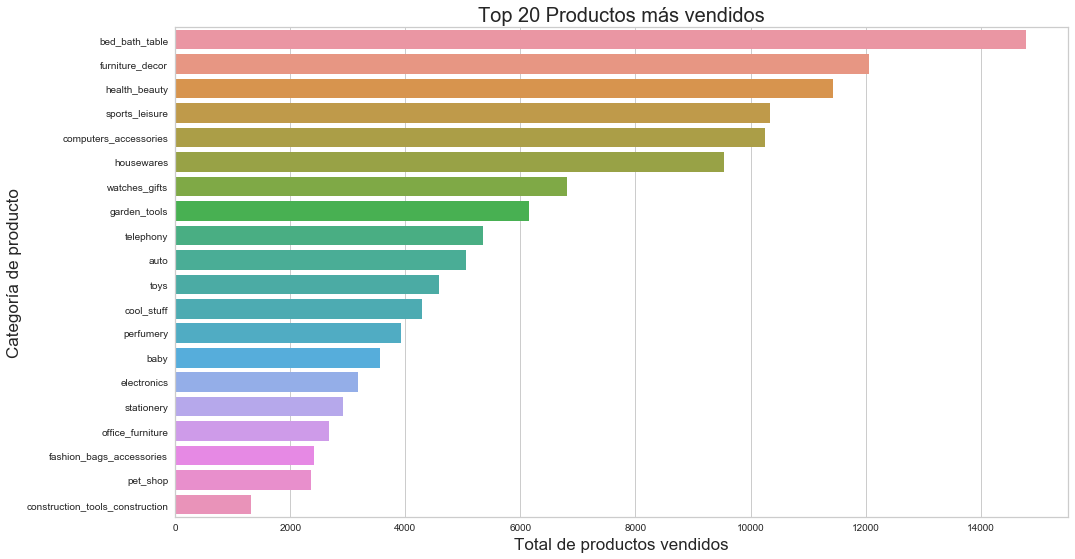

In [7]:
# ¿Qué productos tienen más demanda?
top_20_product_best_seller = all_data['order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]
#print(top_20_product_best_seller)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values)
plt.title('Top 20 Productos más vendidos',fontsize=20)
plt.xlabel('Total de productos vendidos',fontsize=17)
plt.ylabel('Categoría de producto',fontsize=17)

Text(0, 0.5, 'Ciudad')

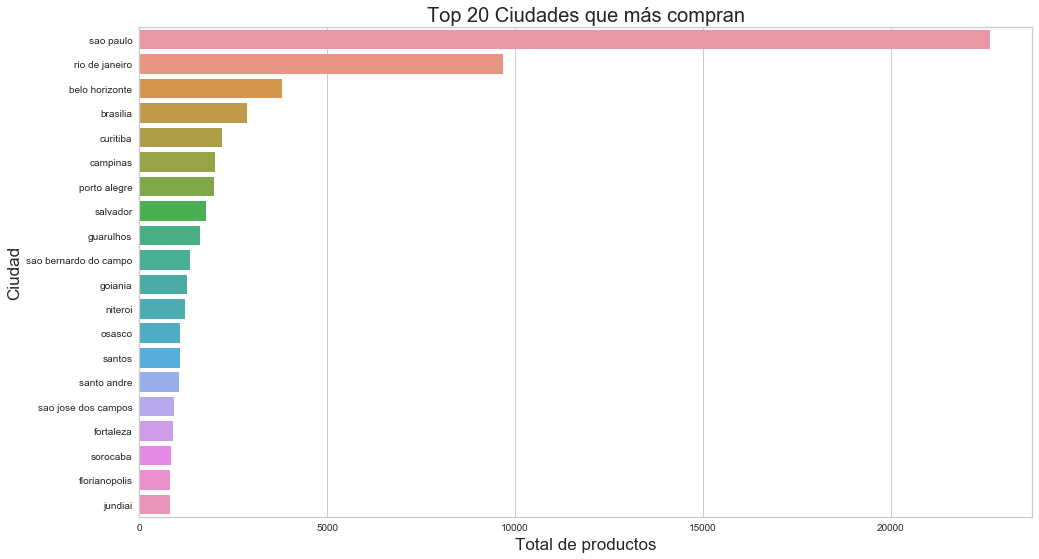

In [8]:
top_20_city_shopping = all_data['order_item_id'].groupby(all_data['customer_city']).sum().sort_values(ascending=False)[:20]
#print(top_20_city_shopping)

# ¿Qué ciudad compra más?
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_shopping.index,x=top_20_city_shopping.values)
plt.title('Top 20 Ciudades que más compran',fontsize=20)
plt.xlabel('Total de productos',fontsize=17)
plt.ylabel('Ciudad',fontsize=17)

Text(0, 0.5, 'ID de cliente')

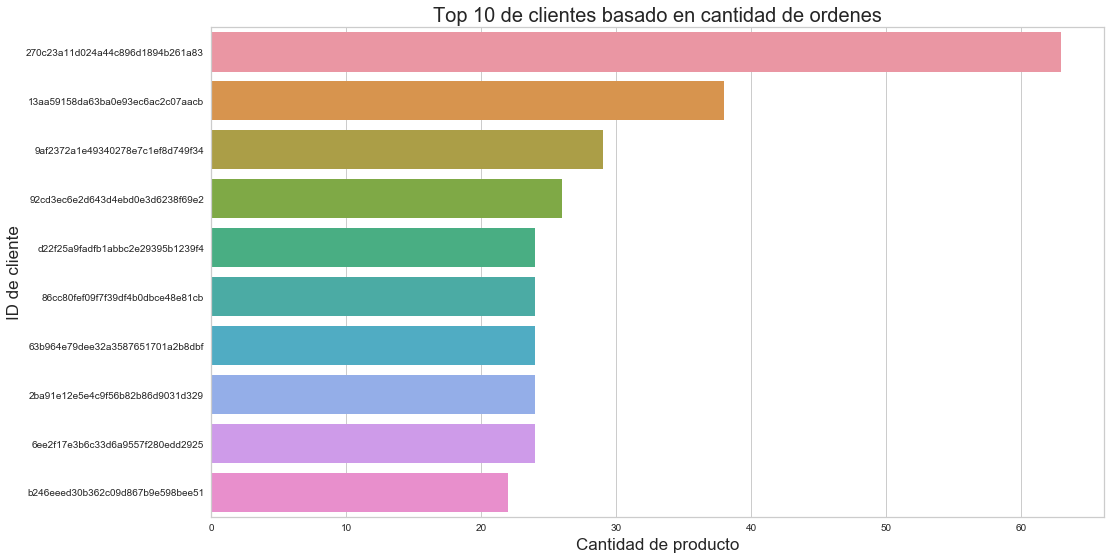

In [9]:
# ¿Quién tiene el mayor número de compras en función de la cantidad de pedidos?
top_10_customer_shopping = all_data['order_item_id'].groupby(all_data['customer_id']).count().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 de clientes basado en cantidad de ordenes',fontsize=20)
plt.xlabel('Cantidad de producto',fontsize=17)
plt.ylabel('ID de cliente',fontsize=17)

Text(0, 0.5, 'ID del cliente')

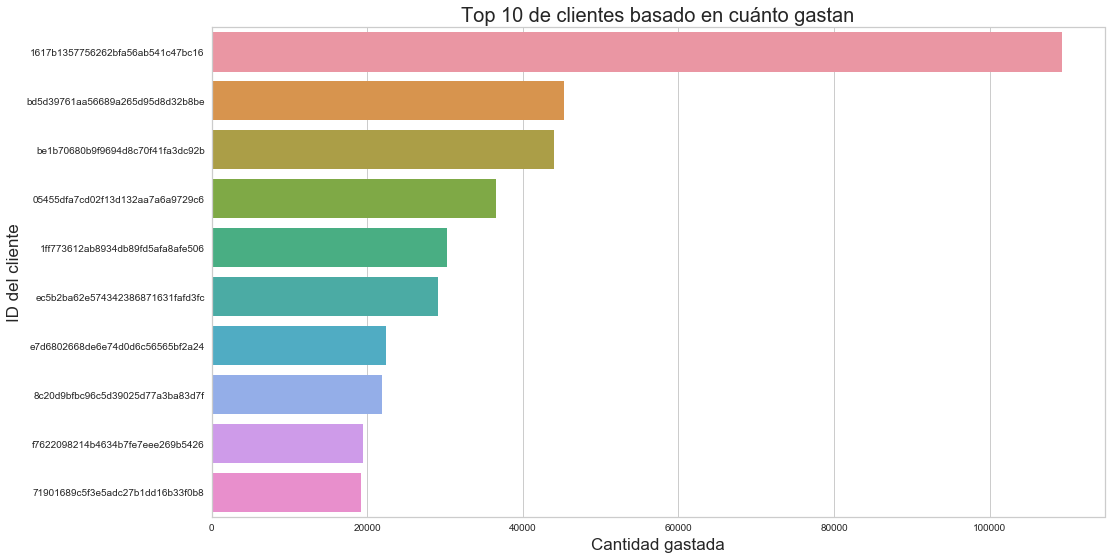

In [10]:
# ¿Quién es el cliente con más gasto en compras por precio?
top_10_customer_shopping = all_data['payment_value'].groupby(all_data['customer_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 de clientes basado en cuánto gastan',fontsize=20)
plt.xlabel('Cantidad gastada',fontsize=17)
plt.ylabel('ID del cliente',fontsize=17)

Text(0, 0.5, 'ID del vendedor')

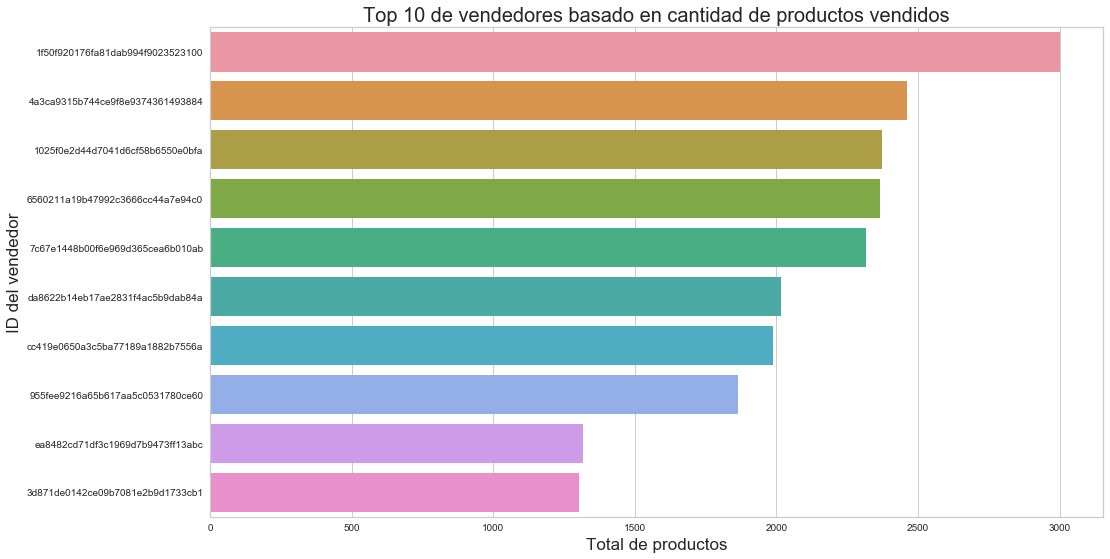

In [11]:
# ¿Qué vendedores venden más? En terminos de cantidad de productos vendidos
top_10_seller_order = all_data['order_item_id'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 de vendedores basado en cantidad de productos vendidos',fontsize=20)
plt.xlabel('Total de productos',fontsize=17)
plt.ylabel('ID del vendedor',fontsize=17)

Text(0, 0.5, 'ID del vendedor')

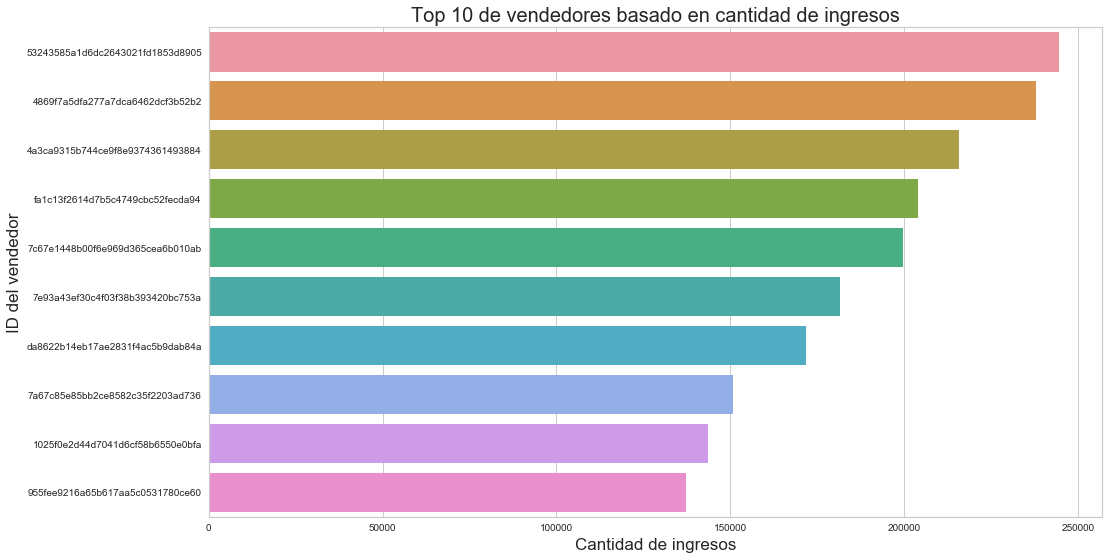

In [12]:
# Vendedor, ¿cuál es el mayor vendedor basado en ingresos?
top_10_seller_order = all_data['price'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 de vendedores basado en cantidad de ingresos',fontsize=20)
plt.xlabel('Cantidad de ingresos',fontsize=17)
plt.ylabel('ID del vendedor',fontsize=17)

Text(0, 0.5, 'ID del vendedor')

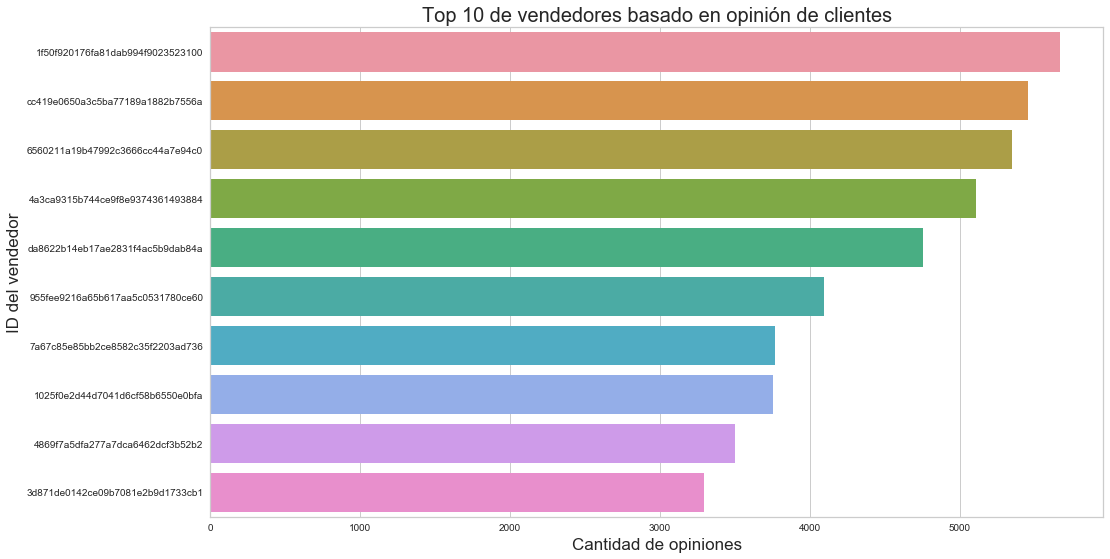

In [13]:
# Vendedor, ¿cuál es el mayor vendedor basado en la review de los clientes?
top_10_seller_order = all_data[all_data['review_score'] == 5].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score)
plt.title('Top 10 de vendedores basado en opinión de clientes',fontsize=20)
plt.xlabel('Cantidad de opiniones',fontsize=17)
plt.ylabel('ID del vendedor',fontsize=17)

In [14]:
# Distribución del estado del pedido del cliente
round(all_data.order_status.value_counts() / len(all_data),2)
#98% de los productos entregados, 1% enviado

delivered     0.98
shipped       0.01
canceled      0.00
processing    0.00
invoiced      0.00
approved      0.00
Name: order_status, dtype: float64

Text(0, 0.5, 'Tiempo (Día)')

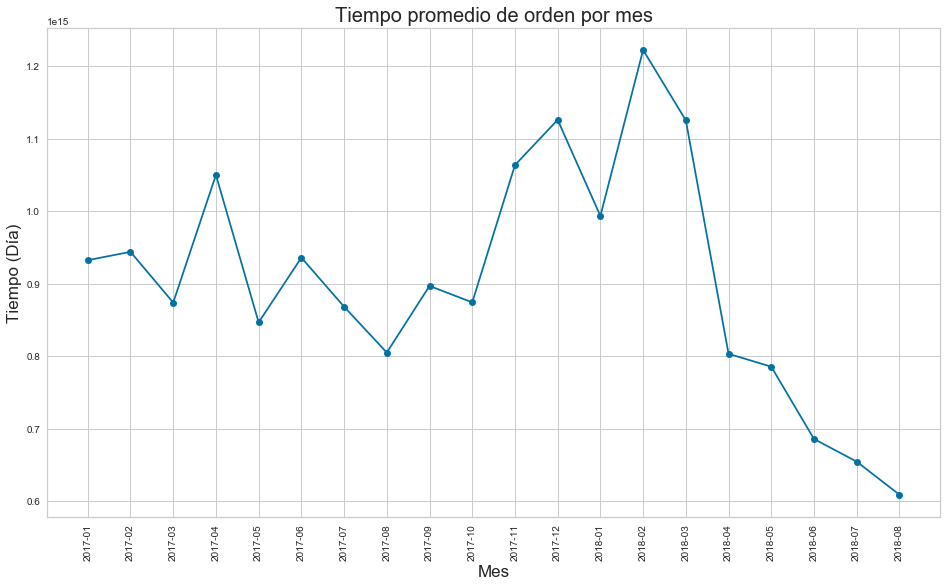

In [15]:
# ¿Cuál es el tiempo promedio desde el pedido hasta el recibo que se necesita en cada pedido mensual?
order_time_by_month = all_data['order_process_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(order_time_by_month.index, order_time_by_month.values, marker='o')
plt.title('Tiempo promedio de orden por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Tiempo (Día)',fontsize=17)

Text(0, 0.5, 'Tiempo (Día)')

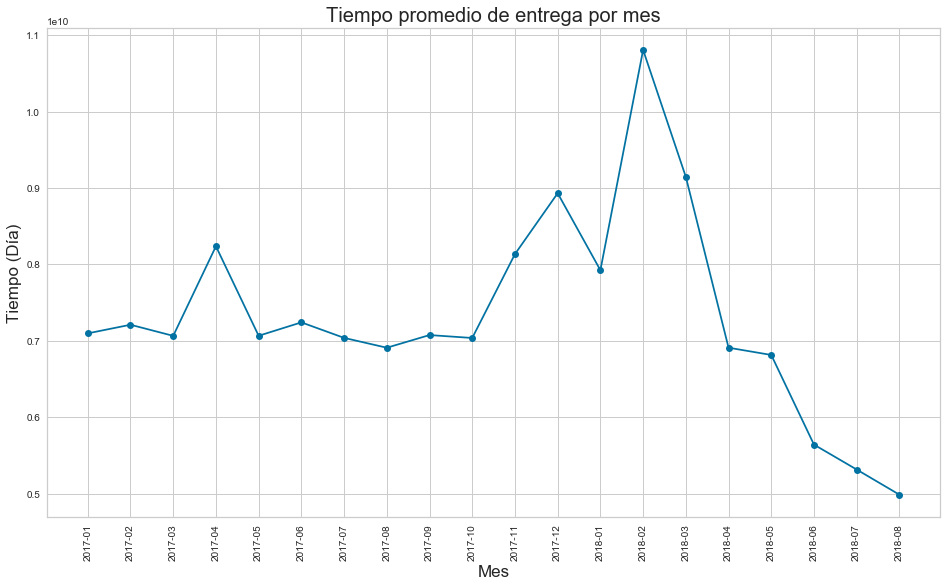

In [16]:
# ¿Cuál es el tiempo de entrega promedio requerido para cada primer pedido?
delivery_time_by_month = all_data['order_delivery_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta


fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o')
plt.title('Tiempo promedio de entrega por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Tiempo (Día)',fontsize=17)

Text(0, 0.5, 'Tiempo (Día)')

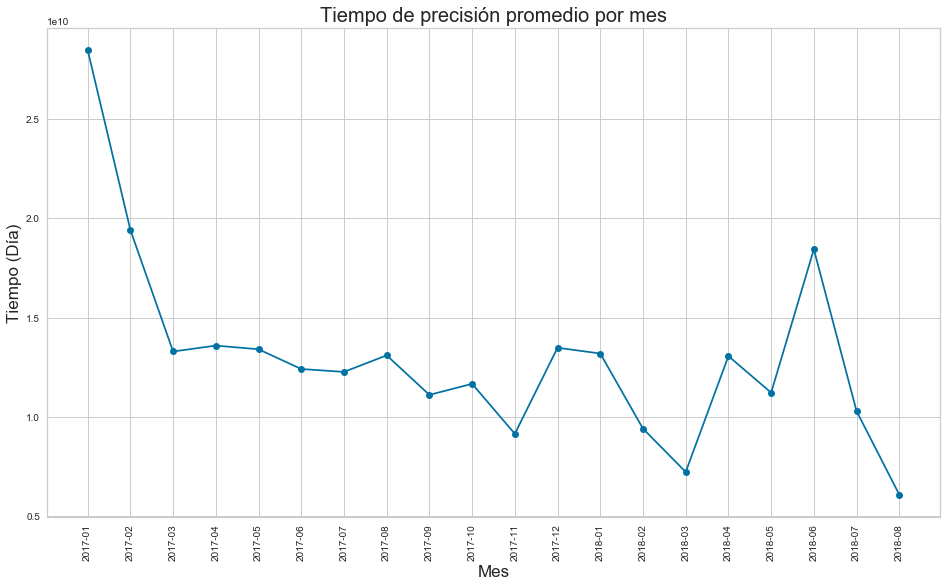

In [17]:
# ¿Cuál es la precisión media del tiempo de los envíos estimados y hasta el cliente en cada pedido mensual?
accuracy_time_by_month = all_data['order_accuracy_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(accuracy_time_by_month.index, accuracy_time_by_month.values / 86400, marker='o')
plt.title('Tiempo de precisión promedio por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Tiempo (Día)',fontsize=17)

Text(0, 0.5, 'Tiempo (Minutos)')

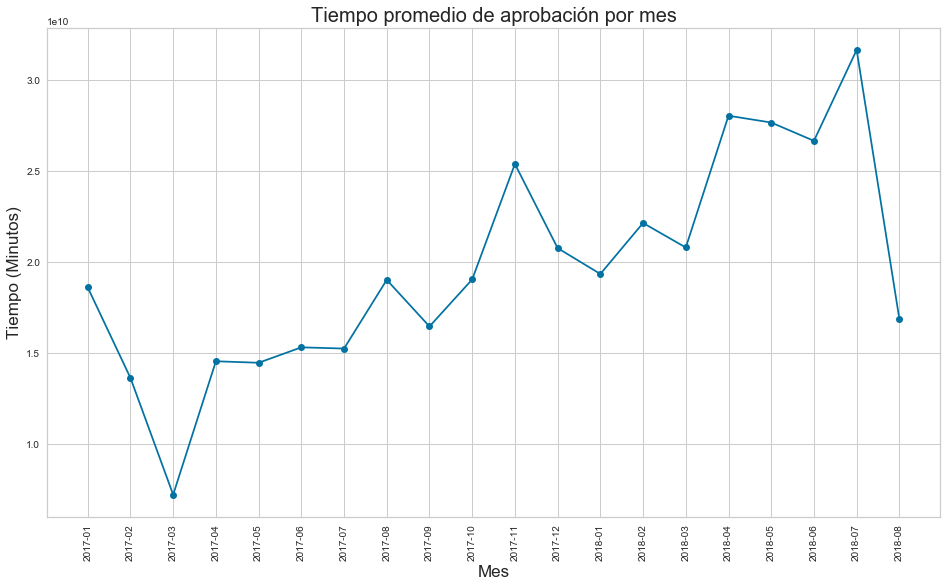

In [18]:
# ¿Cuál es el período de tiempo promedio hasta que se aprueba desde el momento del pedido en cada pedido mensual?
approved_time_by_month = all_data['order_approved_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(approved_time_by_month.index, approved_time_by_month.values / 60, marker='o')
plt.title('Tiempo promedio de aprobación por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Tiempo (Minutos)',fontsize=17)

Text(0, 0.5, 'Categoría del producto')

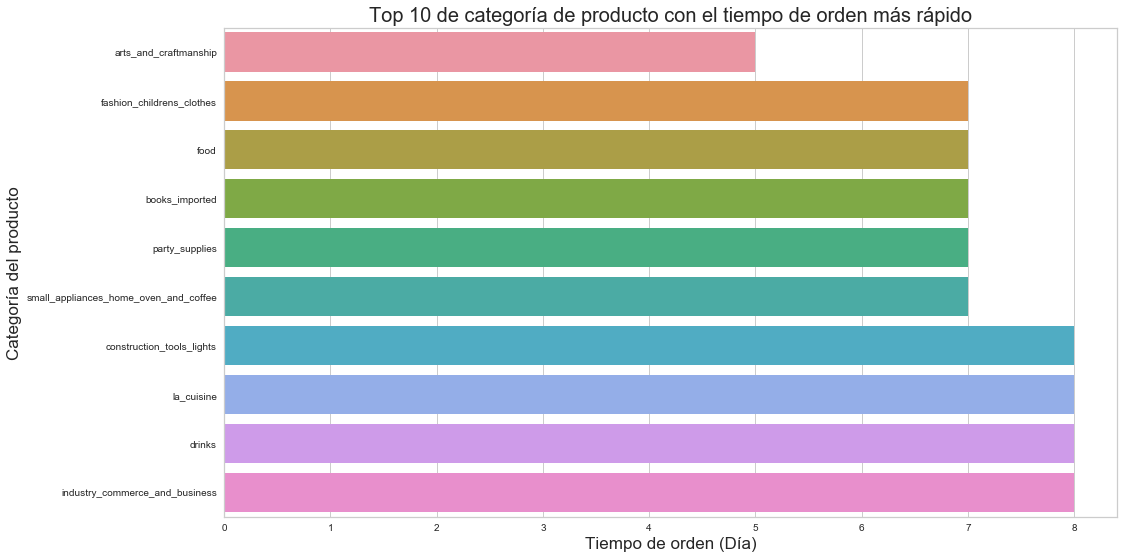

In [19]:
# 10 categorías de productos con el tiempo más rápido desde el pedido hasta la aceptación del cliente
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=True)[:10])

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 de categoría de producto con el tiempo de orden más rápido',fontsize=20)
plt.xlabel('Tiempo de orden (Día)',fontsize=17)
plt.ylabel('Categoría del producto',fontsize=17)

Text(0, 0.5, 'Categoría de producto')

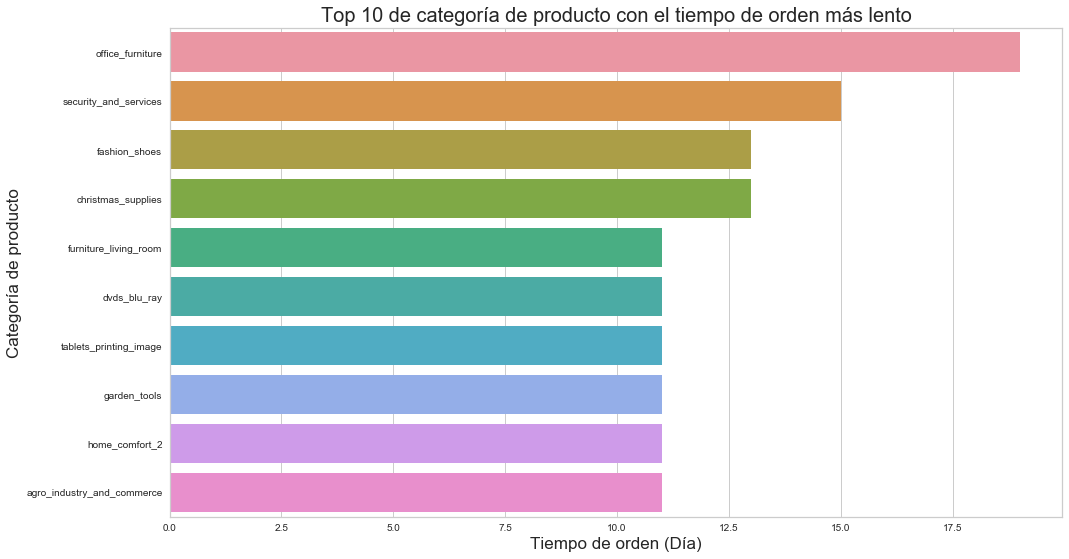

In [20]:
# 10 categorías de productos con el mayor tiempo desde el pedido hasta la aceptación del cliente
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=False)[:10])

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 de categoría de producto con el tiempo de orden más lento',fontsize=20)
plt.xlabel('Tiempo de orden (Día)',fontsize=17)
plt.ylabel('Categoría de producto',fontsize=17)

Text(0, 0.5, 'Cantidad de ordenes')

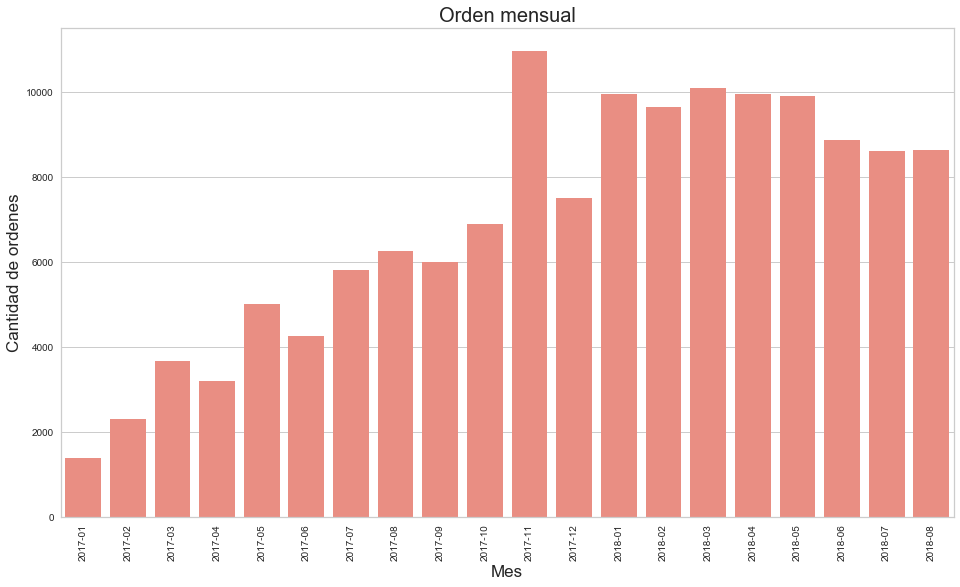

In [21]:
# ¿Cuánto cuesta el pedido cada mes?
order_count_by_month = all_data['order_item_id'].groupby(all_data['Month_order']).sum()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_count_by_month.values, x=order_count_by_month.index, color="Salmon")
plt.title('Orden mensual',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Cantidad de ordenes',fontsize=17)

Text(0, 0.5, 'Cantidad de ingresos')

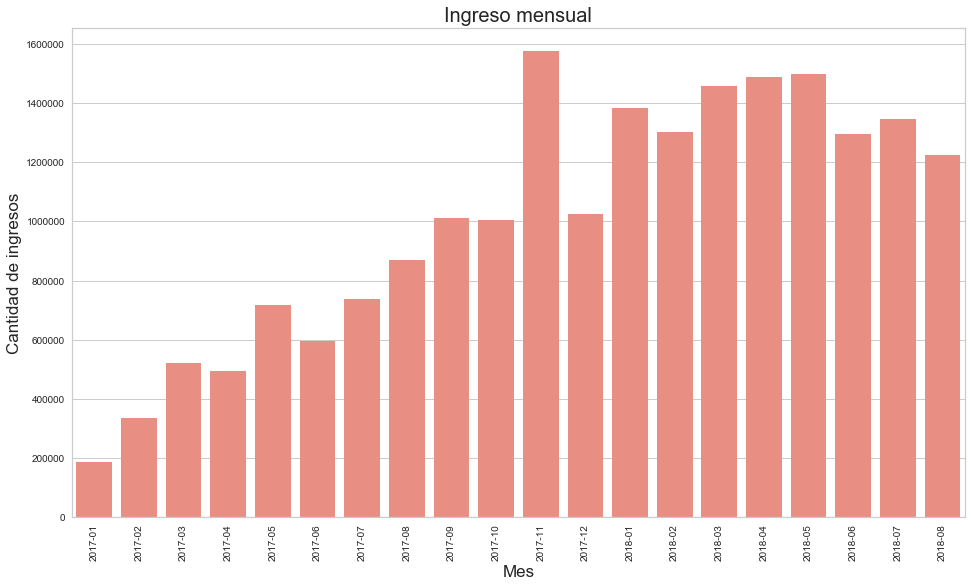

In [22]:
# ¿Cuánto es el ingreso mensual?
revenue_count_by_month = all_data['payment_value'].groupby(all_data['Month_order']).sum()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=revenue_count_by_month.values, x=revenue_count_by_month.index, color="Salmon")
plt.title('Ingreso mensual',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Cantidad de ingresos',fontsize=17)

Text(0, 0.5, 'Cantidad de usuarios')

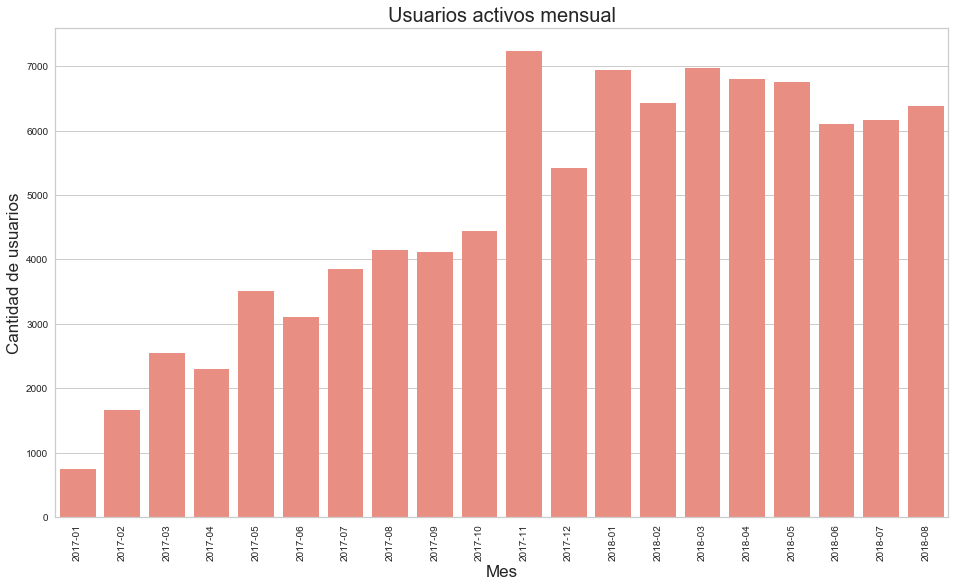

In [23]:
# ¿Cómo son los clientes activos cada mes?
customer_active_by_month = all_data.groupby('Month_order')['customer_unique_id'].nunique().reset_index()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=customer_active_by_month['customer_unique_id'], x=customer_active_by_month['Month_order'], color="Salmon")
plt.title('Usuarios activos mensual',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Cantidad de usuarios',fontsize=17)

# ** 3. Modelado **

En esta etapa, el modelado se llevará a cabo utilizando un algoritmo de agrupamiento denominado K-Means basado en el análisis RFM (Recency, Frequency, and Monetary) para la segmentación de clientes.

## ** 3.1 Análisis RFM **

El análisis RFM es un método utilizado para ver patrones en los clientes en función de sus hábitos de compra:

1. Recency = ¿Cuándo fue la última vez que el cliente realizó una transacción?
 
2. Frecuencia = ¿Con qué frecuencia el cliente realiza una compra?

3. Monetario = cuánto gastan los clientes

In [24]:
#ver las fechas de compra e inicio
print('Min : {}, Max : {}'.format(min(all_data.order_purchase_timestamp), max(all_data.order_purchase_timestamp)))

Min : 2017-01-05 11:56:06, Max : 2018-08-29 15:00:37


In [25]:
#Calcular RFM
import datetime as dt
pin_date = max(all_data.order_purchase_timestamp) + dt.timedelta(1)

#Creo un dataframe para RFM
rfm = all_data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp' : lambda x: (pin_date - x.max()).days,
    'order_item_id' : 'count', 
    'payment_value' : 'sum'})
#este dataframe va a contener hace cuantos dias hicieron la ultima compra, cuantos productos compraron en el periodo
#bajo estudio y cuanto gastaron en esos productos, en el mismo periodo

rfm.rename(columns = {'order_purchase_timestamp' : 'Recency', 
                      'order_item_id' : 'Frequency', 
                      'payment_value' : 'Monetary'}, inplace = True)

rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
0000f46a3911fa3c0805444483337064,537,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
0004aac84e0df4da2b147fca70cf8255,288,1,196.89


## ** 3.2 Manejo de valores atípicos **

En esta etapa, limpiaremos los datos de las entradas que pueden ser incorrectas o las anomalías de los datos que tenemos.

In [26]:
#Usamos Rangos intercuartilicos
def limit(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.5) + (IQR * 3)
    print('Lower Limit:', lower_limit)
    print('Lower Limit Extreme:', lower_limit_extreme)
    print('Upper Limit:', upper_limit)
    print('Upper Limit Extreme:', upper_limit_extreme)

def percent_outliers(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.95) + (IQR * 3)
    print('Lower Limit: {} %'.format(rfm[(rfm[i] >= lower_limit)].shape[0]/ rfm.shape[0]*100))
    print('Lower Limit Extereme: {} %'.format(rfm[(rfm[i] >= lower_limit_extreme)].shape[0]/rfm.shape[0]*100))
    print('Upper Limit: {} %'.format(rfm[(rfm[i] >= upper_limit)].shape[0]/ rfm.shape[0]*100))
    print('Upper Limit Extereme: {} %'.format(rfm[(rfm[i] >= upper_limit_extreme)].shape[0]/rfm.shape[0]*100))

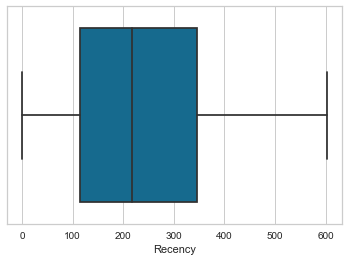

In [27]:
sns.boxplot(x=rfm["Recency"])

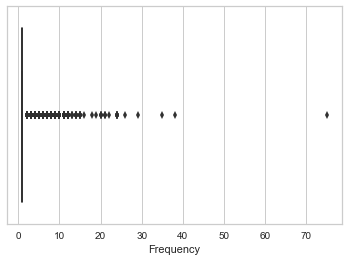

In [28]:
sns.boxplot(x=rfm["Frequency"])

La columna Frecuencia no elimina los valores atípicos porque los valores atípicos aquí son de hecho la posibilidad de que los clientes realicen muchas transacciones porque estos datos se toman de 2017-2018

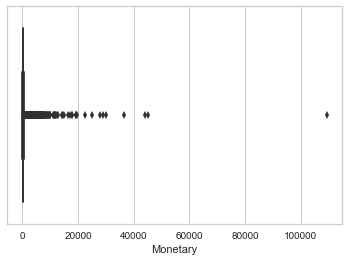

In [29]:
sns.boxplot(x=rfm["Monetary"])

In [30]:
print(limit('Monetary'))
print('-'*50)
print(percent_outliers('Monetary'))

Lower Limit: -719.16
Lower Limit Extreme: -1551.4499999999998
Upper Limit: 1500.28
Upper Limit Extreme: 1777.71
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 1.2549312293421473 %
Upper Limit Extereme: 0.5363045100757011 %
None


In [31]:
#se eliminan los valores outliers de aquellos que hayan gastado mas de 1500 
outliers1_drop = rfm[(rfm['Monetary'] > 1500)].index
rfm.drop(outliers1_drop, inplace=True)

## ** 3.3 Percentil RFM **

En esta etapa, se crearán grupos de clientes basados ​​en Recency, Frequency y Monetary dividiéndolos en grupos de 3 **** en cada uno.

In [32]:
# Crear grupos de clientes basados en Recency, Frequency y Monetary
#Porque en Recency cuantos menos días pasaron desde la ultima compra mejor
r_labels = range(3, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 3, labels = r_labels).astype('int')

# Debido a que en la frecuencia vemos muchos valores igual a 1, entonces no puede usar qcut,
#porque el valor se apoyará más
f_groups = pd.qcut(rfm.Frequency.rank(method='first'), 3).astype('str')
#rfm['F'] = np.where((rfm['Frequency'] != 1) & (rfm['Frequency'] != 2), 3, rfm.Frequency)

m_labels = range(1, 4)
m_groups = pd.qcut(rfm.Monetary, q = 3, labels = m_labels).astype('int')

In [33]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [34]:
rfm['F'].value_counts()

(61741.667, 92612.0]      30871
(0.999, 30871.333]        30871
(30871.333, 61741.667]    30870
Name: F, dtype: int64

In [35]:
rfm['F'] = rfm['F'].replace({'(0.999, 30871.333]' : 1,
                             '(30871.333, 61741.667]' : 2,
                             '(61741.667, 92612.0]' : 3}).astype('int')

In [36]:
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6


In [37]:
score_labels = ['Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q=3, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6,Silver
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5,Bronze
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4,Bronze
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3,Bronze
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6,Silver


## ** 3.4 Manejo de la inclinación y el escalado **

Para los datos que ingresarán al algoritmo K-Means, la distribución es normal porque facilitará la formación de grupos, luego no olvides igualar la escala de cada columna porque se medirá en función de la distancia entre cada entrada.

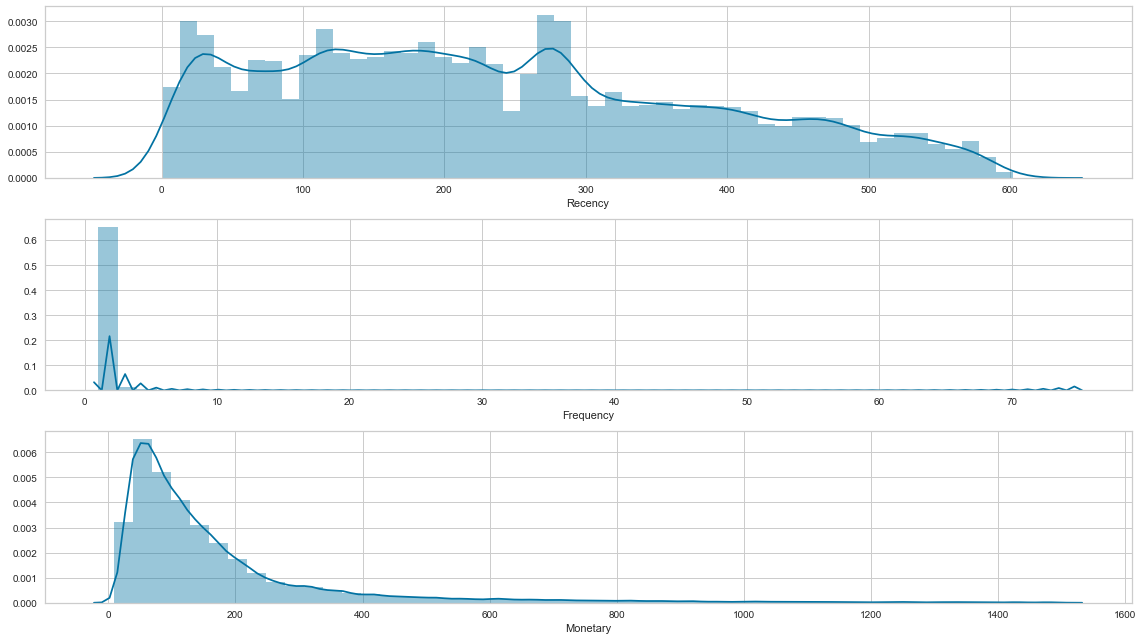

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'], kde_kws={'bw': 0.1}, label='Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

In [39]:
from scipy import stats

rfm_log = rfm[['Recency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
rfm_log.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.718,4.955,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.745,3.303,0.0
0000f46a3911fa3c0805444483337064,6.286,4.457,0.0
0000f6ccb0745a6a4b88665a16c9f078,5.771,3.776,0.0
0004aac84e0df4da2b147fca70cf8255,5.663,5.283,0.0


In [40]:
scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [41]:
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.456069,0.220580,-0.408549
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427655,-1.712288,-0.408549
0000f46a3911fa3c0805444483337064,1.194001,-0.362089,-0.408549
0000f6ccb0745a6a4b88665a16c9f078,0.652046,-1.158870,-0.408549
0004aac84e0df4da2b147fca70cf8255,0.538393,0.604345,-0.408549


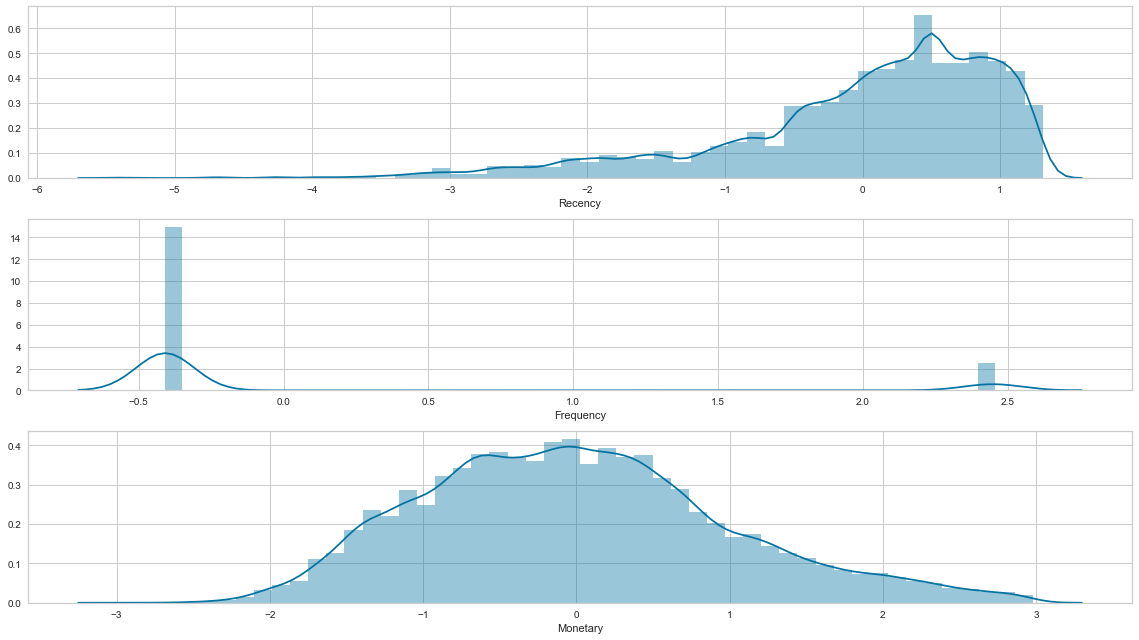

In [42]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, kde_kws={'bw': 0.1}, label='Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

## ** 3.5 Agrupamiento de K-Means **

Aquí la agrupación se realizará utilizando el algoritmo K-Means para obtener el grupo óptimo de datos RFM

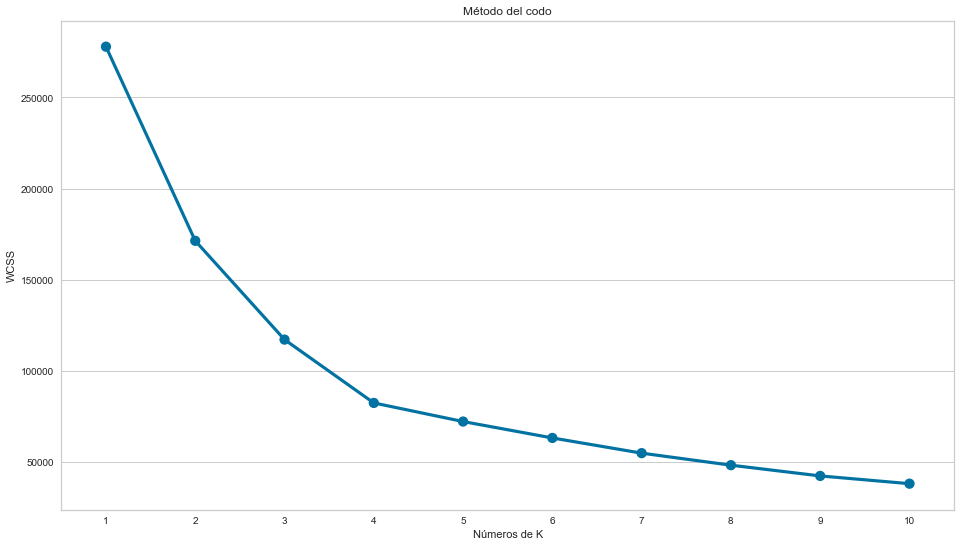

In [43]:
wcss = {}

for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_
    
fig, ax = plt.subplots(figsize=(16, 9))
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.title('Método del codo')
plt.xlabel('Números de K')
plt.ylabel('WCSS')
plt.show()

Podemos observar en el grafico que la clusterizacion optima se encuentra entre 3 y 5 por lo que realizaremos la evaluacion y 
visualizacion con 3, 4 y 5 clusters para luego elegir aquellos que mejores resultados den.

## Clusterización con k=3

In [44]:
clus = KMeans(n_clusters= 3, n_init=10, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(n_clusters=3)

In [45]:
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6,Silver,1
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4,Bronze,1
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6,Silver,1


## ** 3.6 Evaluación **

Después de crear un modelo usando KMeans, ahora evaluaremos el modelo si los grupos que forma son realmente diferentes de cada grupo usando el Análisis de Silhouuette. Cuanto más se acerca al número 1, la diferencia que tiene con otras computadoras es cada vez más clara, si el valor está cerca de 0, entonces se parece cada vez más a un grupo cercano y, si -1, hizo un grupo incorrecto.

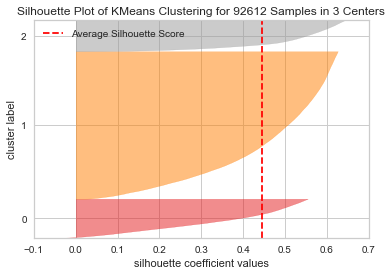

In [46]:
visualizer = SilhouetteVisualizer(clus)

visualizer.fit(rfm_scaled) 
visualizer.poof() 

## ** 3.7 Visualización **

Visualizaremos para que sea más fácil ver el clúster que creamos con el clúster del algoritmo KMeans. Usaremos 'Snake Plot' en el mundo del marketing para ver qué categorías se incluyen en un clúster.



In [47]:
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,customer_unique_id,Recency,Monetary,Frequency,K_Cluster,RFM_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.456069,0.220580,-0.408549,1,Silver
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427655,-1.712288,-0.408549,1,Bronze
2,0000f46a3911fa3c0805444483337064,1.194001,-0.362089,-0.408549,1,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,0.652046,-1.158870,-0.408549,1,Bronze
4,0004aac84e0df4da2b147fca70cf8255,0.538393,0.604345,-0.408549,1,Silver


In [48]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customer_unique_id', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,customer_unique_id,RFM_Level,K_Cluster,Metrics,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,Silver,1,Recency,-0.456069
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Bronze,1,Recency,-0.427655
2,0000f46a3911fa3c0805444483337064,Bronze,1,Recency,1.194001
3,0000f6ccb0745a6a4b88665a16c9f078,Bronze,1,Recency,0.652046
4,0004aac84e0df4da2b147fca70cf8255,Silver,1,Recency,0.538393


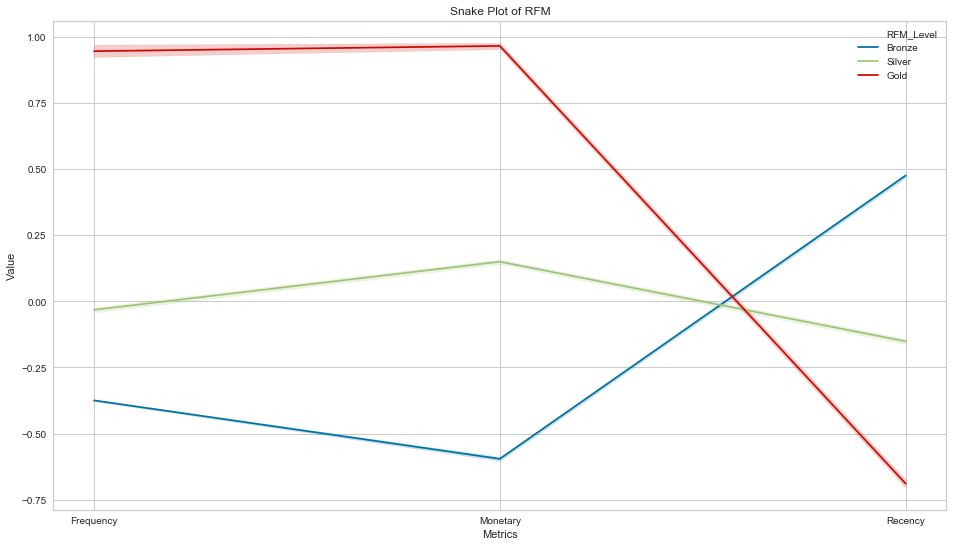

In [49]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

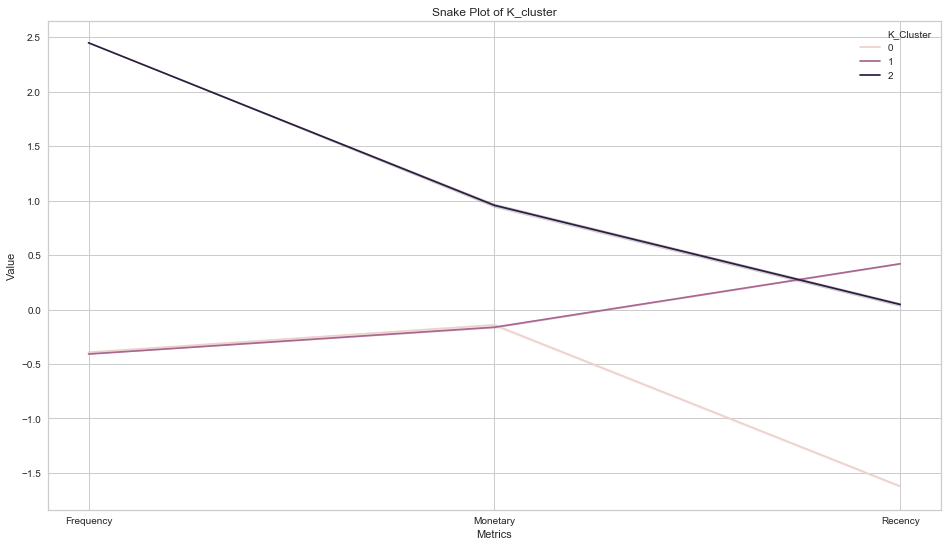

In [50]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

Como podemos ver en los dos gráficos anteriores, podemos concluir con base en grupos:
1. Bronce (1 y 0): la frecuencia no es demasiado alta en comparación con la transacción nominal, pero la última vez que realizó una transacción rápida
2. Plata (2): la frecuencia es bastante alta y la transacción nominal es bastante alta, pero la última vez que realizó una transacción fue bastante larga
3. Oro (3): la frecuencia de gasto es alta y la cantidad gastada también es alta, pero el tiempo de transacción es largo

Text(0, 0.5, 'Cantidad de clientes')

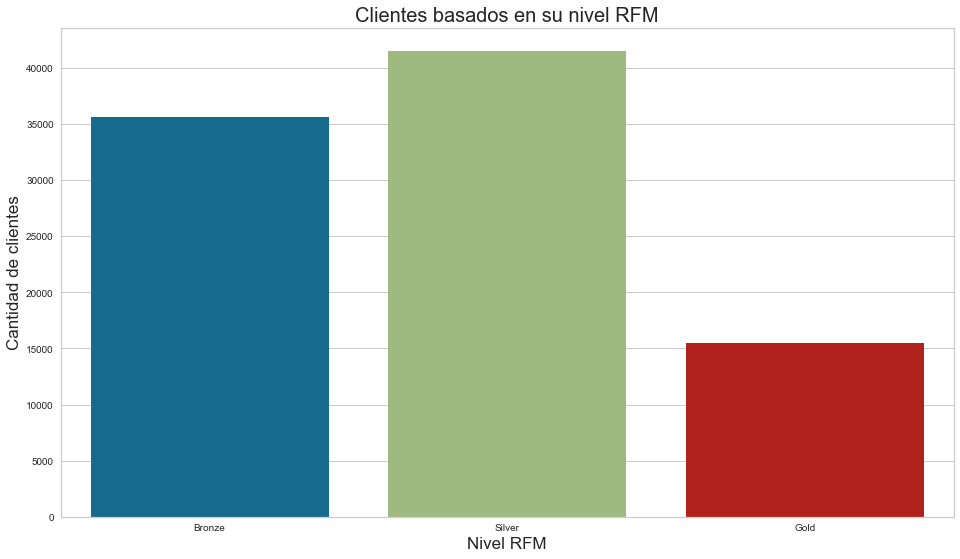

In [51]:
# ¿Cuántos clientes hay según su categoría?
rfm_cus_level = rfm_scaled.groupby('RFM_Level')['customer_unique_id'].nunique().reset_index()


fig=plt.figure(figsize=(16,9))
sns.barplot(y=rfm_cus_level['customer_unique_id'], x=rfm_cus_level['RFM_Level'])
plt.title('Clientes basados en su nivel RFM',fontsize=20)
plt.xlabel('Nivel RFM',fontsize=17)
plt.ylabel('Cantidad de clientes',fontsize=17)

## Clusterización con k=5

In [52]:
#Por ultimo realizaremos el mismo analisis pero para 5 clusters 

#Crearemos grupos teniendo en cuenta recency, frecuency y monetary diviendolos en grupos de 5

# Crear grupos de clientes basados en Recency, Frequency y Monetary
#En Recency cuantos menos días pasaron desde la ultima compra mejor es
r_labels = range(5, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 5, labels = r_labels).astype('int')

f_groups = pd.qcut(rfm.Frequency.rank(method='first'), 5).astype('str')

m_labels = range(1, 6)
m_groups = pd.qcut(rfm.Monetary, q = 5, labels = m_labels).astype('int')

In [53]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [54]:
rfm['F'].value_counts()

(0.999, 18523.2]      18523
(74089.8, 92612.0]    18523
(37045.4, 55567.6]    18522
(55567.6, 74089.8]    18522
(18523.2, 37045.4]    18522
Name: F, dtype: int64

In [55]:
#reemplazaremos los rangos por los valores 1, 2, 3, 4 y 5
rfm['F'] = rfm['F'].replace({'(0.999, 18523.2]' : 1,
                             '(74089.8, 92612.0]' : 2,
                             '(37045.4, 55567.6]' : 3,
                             '(55567.6, 74089.8]' : 4,
                             '(18523.2, 37045.4]' : 5}).astype('int')

In [56]:
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,9,Silver,1
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,6,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,1
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,7,Silver,1


In [57]:
#le pondremos nombre a nuestras 5 categorias que representaran los grupos de clientes 
score_labels = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']
score_groups = pd.qcut(rfm.RFM_Score, q=5, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,9,Gold,1
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,6,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,1
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,7,Bronze,1


In [58]:
#Inclinacion y escalonado 

rfm_log = rfm[['Recency', 'Monetary']].apply(np.log, axis = 1).round(4)
rfm_log['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
rfm_log.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.7185,4.9551,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.7449,3.3028,0.0
0000f46a3911fa3c0805444483337064,6.2860,4.4569,0.0
0000f6ccb0745a6a4b88665a16c9f078,5.7714,3.7755,0.0
0004aac84e0df4da2b147fca70cf8255,5.6630,5.2826,0.0


In [59]:
scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.455564,0.220701,-0.408549
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427783,-1.712509,-0.408549
0000f46a3911fa3c0805444483337064,1.193975,-0.362199,-0.408549
0000f6ccb0745a6a4b88665a16c9f078,0.652442,-1.159445,-0.408549
0004aac84e0df4da2b147fca70cf8255,0.538369,0.603880,-0.408549


In [60]:
#Agrupamiento de clusters 
clus = KMeans(n_clusters= 5, n_init=10, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(n_clusters=5)

In [61]:
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,9,Gold,3
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,6,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,3
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,7,Bronze,3


### Evaluación

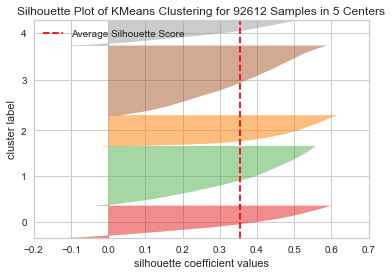

In [62]:
#Evaluaremos el modelo utilizando el metodo de la silueta 

visualizer = SilhouetteVisualizer(clus)

visualizer.fit(rfm_scaled) 
visualizer.poof() 

Podemos observar que con esta nueva distribucion la nueva agrupacion no es tan buena como las anteriores

El score del metodo de silueta nos esta dando menos de 0.4 y los grupos estan siendo muy diferentes entre si 

### Visualización

In [63]:
##Visualizacion de los clusters

rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,customer_unique_id,Recency,Monetary,Frequency,K_Cluster,RFM_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.455564,0.220701,-0.408549,3,Gold
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427783,-1.712509,-0.408549,1,Bronze
2,0000f46a3911fa3c0805444483337064,1.193975,-0.362199,-0.408549,3,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,0.652442,-1.159445,-0.408549,1,Bronze
4,0004aac84e0df4da2b147fca70cf8255,0.538369,0.603880,-0.408549,3,Bronze


In [64]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customer_unique_id', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,customer_unique_id,RFM_Level,K_Cluster,Metrics,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,Gold,3,Recency,-0.455564
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Bronze,1,Recency,-0.427783
2,0000f46a3911fa3c0805444483337064,Bronze,3,Recency,1.193975
3,0000f6ccb0745a6a4b88665a16c9f078,Bronze,1,Recency,0.652442
4,0004aac84e0df4da2b147fca70cf8255,Bronze,3,Recency,0.538369


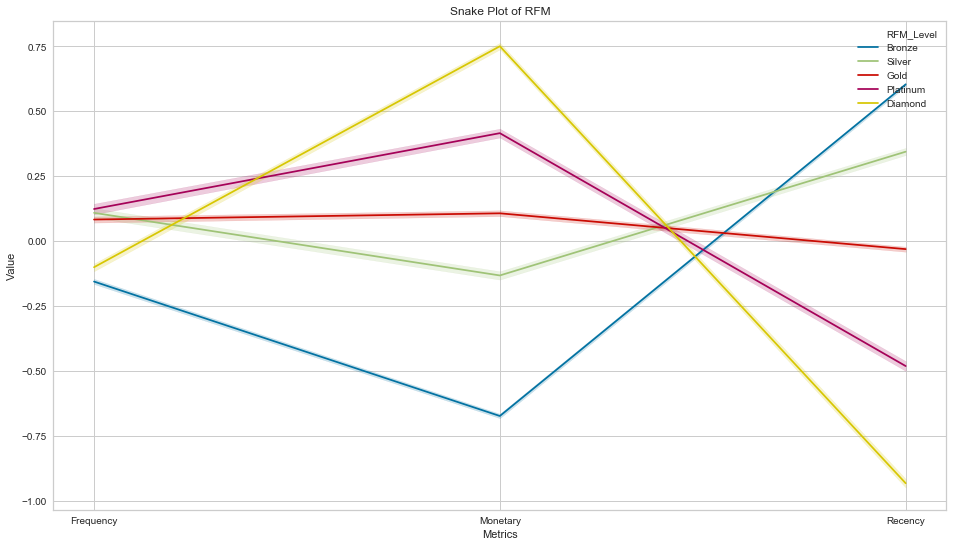

In [65]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

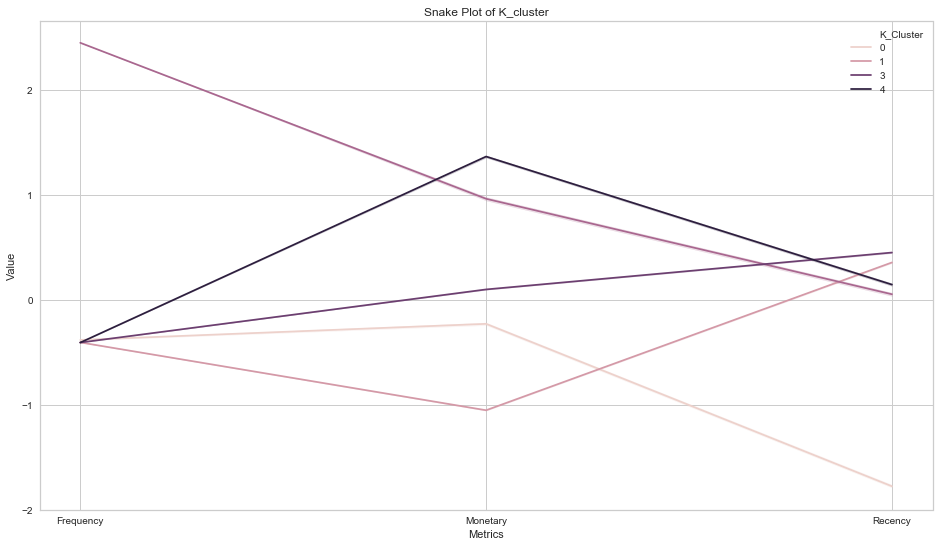

In [66]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

Observandolos graficos anteriores podemos observar como se comportan los 5 grupos 
1. Diamond: frecuencia de compra muy alta, valor monetario de gasto alto, y compro por ultima vez hace muy poco
2. Platinum: frecuencia de compra muy alta, valor monetario de gasto alto, y compro por ultima vez hace poco
3. Gold: frecuencia de compra media, valor monetario de gasto medio, y compro por ultima vez ni hace mucho ni hace muy poco
4. Silver: frecuencia de compra media, valor monetario de gasto medio bajo, y compro por ultima vez hace mucho
5. Bronze: frecuencia de compra muy bajo, valor monetario de gasto muy bajo, y compro por ultima vez hace muchisimo 

Text(0, 0.5, 'Cantidad de clientes')

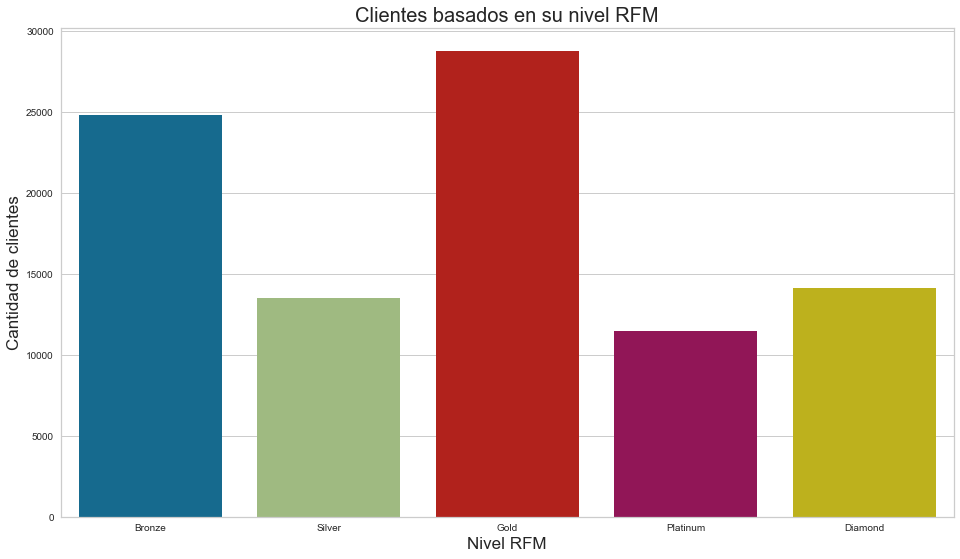

In [67]:
# ¿Cuántos clientes hay según su categoría?
rfm_cus_level = rfm_scaled.groupby('RFM_Level')['customer_unique_id'].nunique().reset_index()


fig=plt.figure(figsize=(16,9))
sns.barplot(y=rfm_cus_level['customer_unique_id'], x=rfm_cus_level['RFM_Level'])
plt.title('Clientes basados en su nivel RFM',fontsize=20)
plt.xlabel('Nivel RFM',fontsize=17)
plt.ylabel('Cantidad de clientes',fontsize=17)

## Clusterización con k=4

In [68]:
#Crearemos grupos teniendo en cuenta recency, frecuency y monetary diviendolos en grupos de 4 

# Crear grupos de clientes basados en Recency, Frequency y Monetary
#En Recency cuantos menos días pasaron desde la ultima compra mejor es
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels).astype('int')

f_groups = pd.qcut(rfm.Frequency.rank(method='first'), 4).astype('str')

m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels).astype('int')

In [69]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [70]:
rfm['F'].value_counts()

(23153.75, 46306.5]    23153
(69459.25, 92612.0]    23153
(0.999, 23153.75]      23153
(46306.5, 69459.25]    23153
Name: F, dtype: int64

In [71]:
#reemplazaremos los rangos por los valores 1, 2, 3 y 4 
rfm['F'] = rfm['F'].replace({'(0.999, 23153.75]' : 1,
                             '(69459.25, 92612.0]' : 2,
                             '(23153.75, 46306.5]' : 3,
                             '(46306.5, 69459.25]' : 4}).astype('int')

In [72]:
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3,413,8,Gold,3
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,311,5,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,3
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,213,6,Bronze,3


In [73]:
#Asignaremos los nuevos labels para estos 4 grupos 
score_labels = ['Frizados', 'Imperdibles', 'Prometedores', 'Campeones']
score_groups = pd.qcut(rfm.RFM_Score, q=4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3,413,8,Imperdibles,3
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,311,5,Frizados,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Frizados,3
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Frizados,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,213,6,Frizados,3


In [74]:
#Inclinacion y escalonado 

rfm_log = rfm[['Recency', 'Monetary']].apply(np.log, axis = 1).round(4)
rfm_log['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
rfm_log.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.7185,4.9551,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.7449,3.3028,0.0
0000f46a3911fa3c0805444483337064,6.2860,4.4569,0.0
0000f6ccb0745a6a4b88665a16c9f078,5.7714,3.7755,0.0
0004aac84e0df4da2b147fca70cf8255,5.6630,5.2826,0.0


In [75]:
scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.455564,0.220701,-0.408549
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427783,-1.712509,-0.408549
0000f46a3911fa3c0805444483337064,1.193975,-0.362199,-0.408549
0000f6ccb0745a6a4b88665a16c9f078,0.652442,-1.159445,-0.408549
0004aac84e0df4da2b147fca70cf8255,0.538369,0.603880,-0.408549


In [76]:
#Agrupamiento de clusters 
clus = KMeans(n_clusters= 4, n_init=10, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(n_clusters=4)

In [77]:
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3,413,8,Imperdibles,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,311,5,Frizados,2
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Frizados,2
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Frizados,2
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,213,6,Frizados,0


### Evaluación

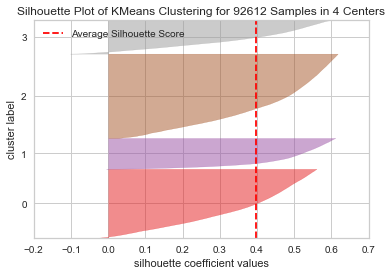

In [78]:
#Evaluaremos el modelo utilizando el metodo de la silueta 

visualizer = SilhouetteVisualizer(clus)

visualizer.fit(rfm_scaled) 
visualizer.poof() 

### Visualización

In [79]:
##Visualizacion de los clusters

rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,customer_unique_id,Recency,Monetary,Frequency,K_Cluster,RFM_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.455564,0.220701,-0.408549,0,Imperdibles
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427783,-1.712509,-0.408549,2,Frizados
2,0000f46a3911fa3c0805444483337064,1.193975,-0.362199,-0.408549,2,Frizados
3,0000f6ccb0745a6a4b88665a16c9f078,0.652442,-1.159445,-0.408549,2,Frizados
4,0004aac84e0df4da2b147fca70cf8255,0.538369,0.603880,-0.408549,0,Frizados


In [80]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customer_unique_id', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,customer_unique_id,RFM_Level,K_Cluster,Metrics,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,Imperdibles,0,Recency,-0.455564
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Frizados,2,Recency,-0.427783
2,0000f46a3911fa3c0805444483337064,Frizados,2,Recency,1.193975
3,0000f6ccb0745a6a4b88665a16c9f078,Frizados,2,Recency,0.652442
4,0004aac84e0df4da2b147fca70cf8255,Frizados,0,Recency,0.538369


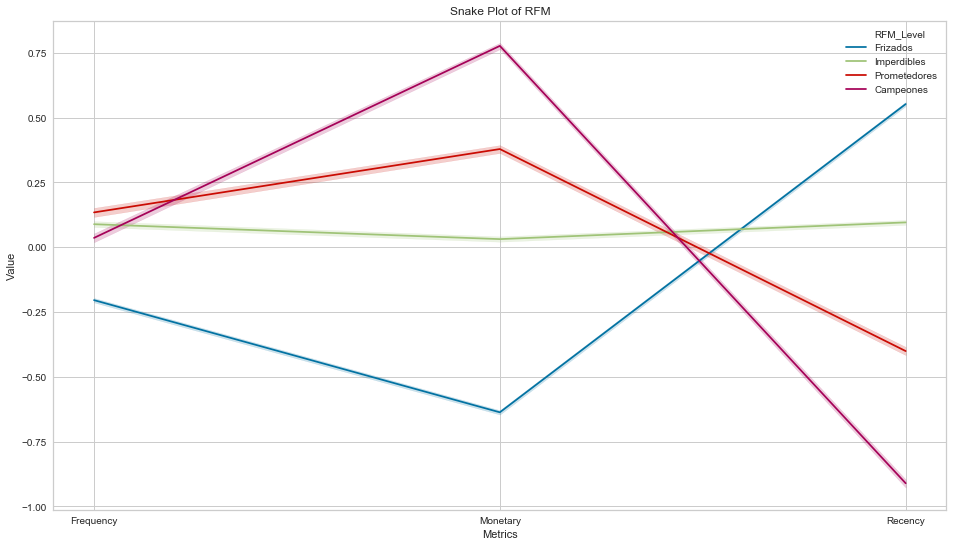

In [81]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

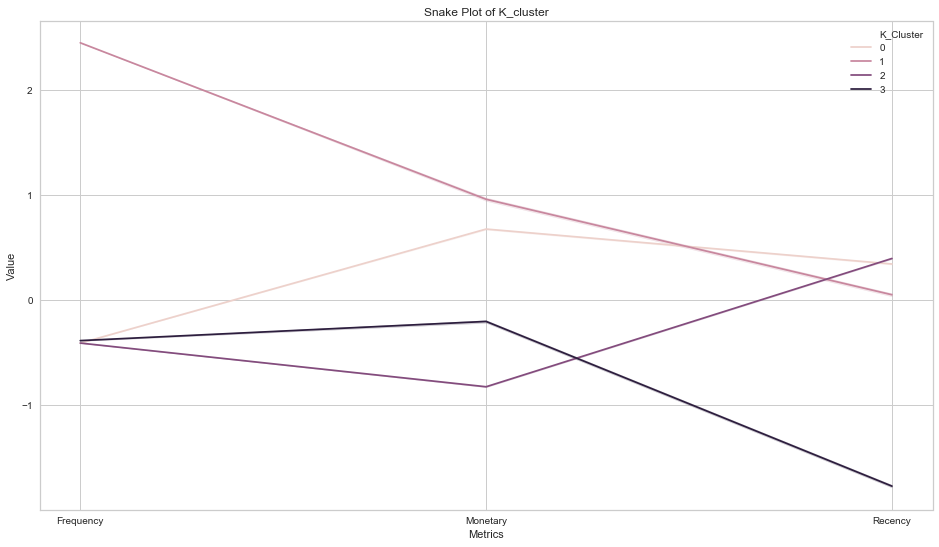

In [82]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

Conclusion de lo observado en los graficos anteriores 
1. Grupo Campeones: podemos observar que la frecuencia de compra es media alta, pero el valor monetario es muy alto y la ultima vez que compro fue hace muy poco 
2. Grupo Prometedores: la frecuencia en que compra es alta, el valor monetario gastado es medio alto (menor al grupo platinum) y compro hace medianamente poco por ultima vez 
3. Grupo Imperdibles: compra con una frecuencia media baja, tiene gastos medios tambien y la ultima compro la realizo hace mucho 
4. Grupo Frizados: la frecuencia con que compran y el valor monetario son muy bajos, y hace mucho mas tiempo que cualquier otro grupo que realizo la ultima compra 

#### ¿Cuántos clientes hay según su categoría?

In [83]:
rfm_cus_level['customer_unique_id']

0    24764
1    13489
2    28747
3    11467
4    14145
Name: customer_unique_id, dtype: int64

Text(0, 0.5, 'Cantidad de clientes')

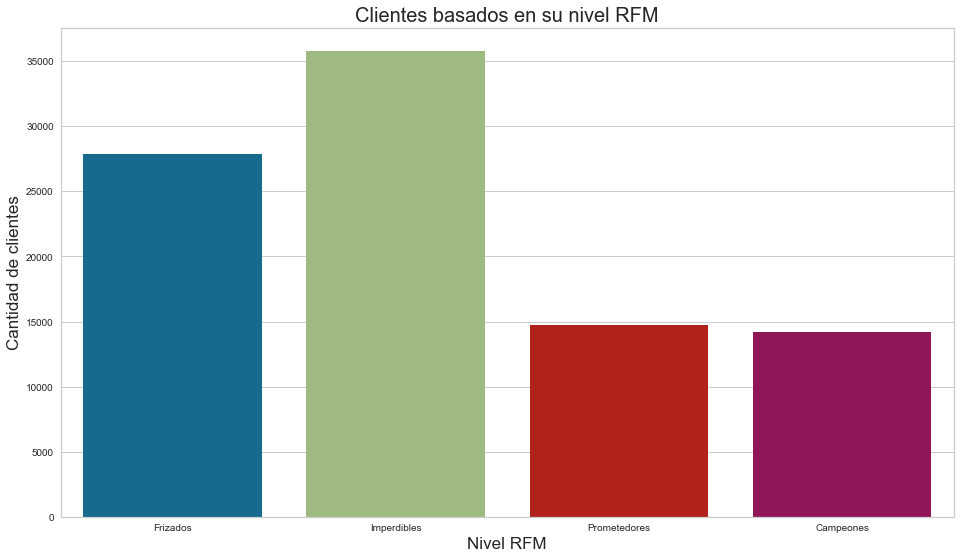

In [84]:
rfm_cus_level = rfm_scaled.groupby('RFM_Level')['customer_unique_id'].nunique().reset_index()


fig=plt.figure(figsize=(16,9))
sns.barplot(y=rfm_cus_level['customer_unique_id'], x=rfm_cus_level['RFM_Level'])
plt.title('Clientes basados en su nivel RFM',fontsize=20)
plt.xlabel('Nivel RFM',fontsize=17)
plt.ylabel('Cantidad de clientes',fontsize=17)

## 4. CONCLUSIÓN
Luego del analisis realizado para clusterizacion de 3, 4 y 5 grupos, elegimos proceder con la clusterizacion en 4 grupos, ya que para 4 grupos la media se encuentra cerca de 0,4 y la distribucion entre los grupos es mas homogenea que para k=3, para el casop de k=5 la media ya nos da por debajo de 0,4 y los grupos son muy distintos entre sí.

A continuación describiremos cada uno de los grupos y la accion a realizar para los mismos. 

En cuanto a los objetivos de este proyecto, que es facilitar que el departamento de marketing lleve a cabo campañas o promociones basadas en la segmentación de clientes, estas son las conclusiones:

* Frizados: son clientes que no realizan compras con demasiada frecuencia, el valor nominal de sus transacciones es muy bajo, y la ultima vez que realizaron una compra fue hace mucho tiempo. Hay 27868 clientes de este tipo. 

** Acción de campaña: posiblemente sean clientes perdidos. En este caso hay que evaluar si vale la pena invertir recursos para recuperarlos. 

* Imperdibles: la frecuencia con que compran es media alta, pero el valor nominal es medio bajo, y la ultima vez que compraron fue hace mucho tiempo. Hay 35792 clientes de este tipo. 

** Acción de campaña: hay peligro de perder estos clientes, hay que analizar sus preferencias para armar productos o combos a su medida. Hay que ofrecerles descuentos u ofertas economicas para que vuelvan a comprar porque es la categoría con mayor cantidad de clientes. 

* Prometedores: son aquellos clientes que compran con mayor frecuencia y el valor monetario gastado es medio alto, la ultima vez que realizaron una compra fue hace medianamente poco. Hay 14763 clientes de este tipo.

** Acción de campaña: son clientes potenciales que realizan muchas compras y podrian convertirse en campeones, hay que buscar convertirlos en campeones a través de ofrecerles beneficios y promociones, por ejemplo, luego de cada compra que realicen. 

* Campeones: si bien la frecuencia de compra no es la mas alta de todas, son los clientes que mayor dinero gastan en sus transacciones y ademas, la ultima vez que compraron fue hace muy poco. Hay 14189 clientes de este tipo.

** Acción de campaña: hay que premiarlos y hacerlos sentir bien para que sigan manteniendo su fidelidad. 

## A continuación determinaremos acciones concretas a realizar para los segmentos más críticos: Imperdibles y Frizados. Para ello compararemos diferencias en las preferencias de compras de cada uno de estos dos segmentos con respecto al conjunto total de compradores.

In [122]:
#Primero unimos la tabla de RFM con ALL_DATA
all_data_rfm= all_data.merge(rfm_scaled, on='customer_unique_id')

Text(0, 0.5, 'Categoría de producto')

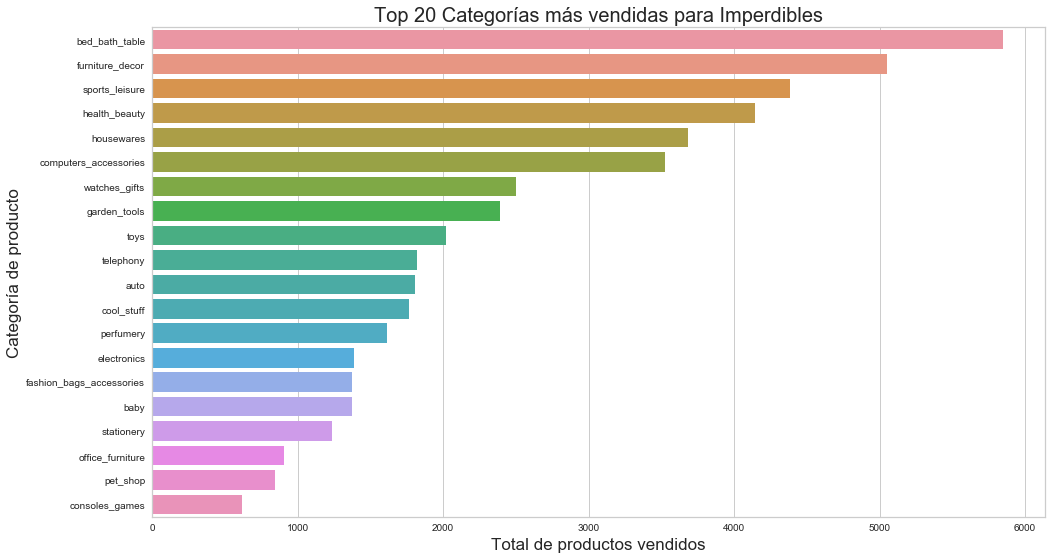

In [123]:
# ¿Qué categoría de productos tienen más demanda para el segmento IMPERDIBLES??
top_20_product_best_seller = all_data_rfm.loc[all_data_rfm['RFM_Level']=='Imperdibles','order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]
#print(top_20_product_best_seller)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values)
plt.title('Top 20 Categorías más vendidas para Imperdibles',fontsize=20)
plt.xlabel('Total de productos vendidos',fontsize=17)
plt.ylabel('Categoría de producto',fontsize=17)

### Acción: Observamos que para este segmento  la categoría de "sport leisure" y "housewares" tienen mayor aceptación que para el conjunto completo de los clientes. Por lo tanto nos enfocaremos en esas categorías para ofrecer promociones especiales mediante una campaña de e-mails masivos.

Text(0, 0.5, 'ID de producto')

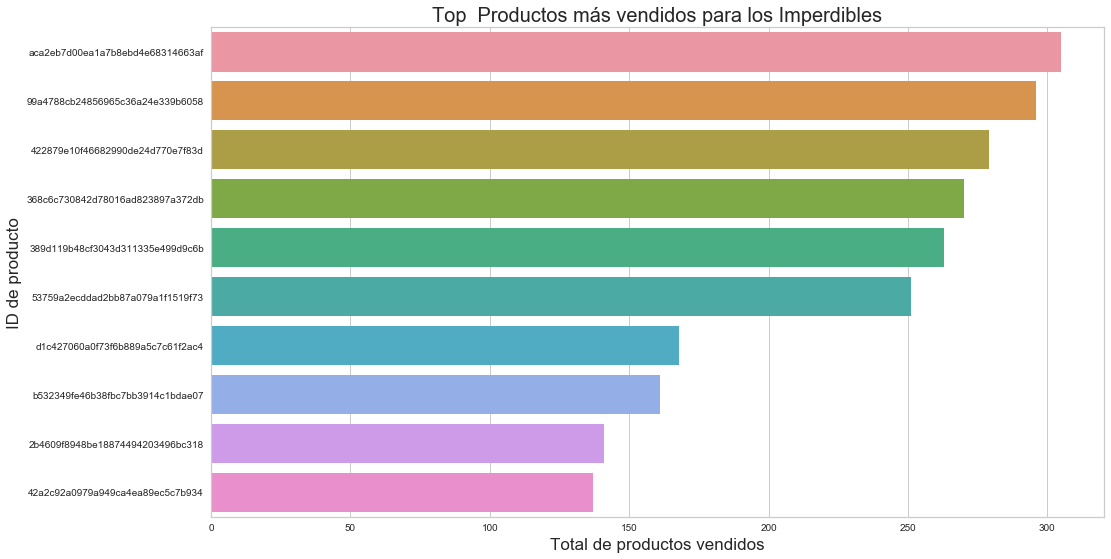

In [125]:
# ¿Qué productos tienen más demanda para el segmento IMPERDIBLES?
top_10_product_best_seller = all_data_rfm.loc[all_data_rfm['RFM_Level']=='Imperdibles','order_item_id'].groupby(all_data_rfm['product_id']).sum().sort_values(ascending=False)[:10]

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_product_best_seller.index,x=top_10_product_best_seller.values)
plt.title('Top  Productos más vendidos para los Imperdibles',fontsize=20)
plt.xlabel('Total de productos vendidos',fontsize=17)
plt.ylabel('ID de producto',fontsize=17)

### Acción: A partir de conocer cuales son los 10 productos mas demandados por el segmento Imperdibles ofreceremos el beneficio de envío gratuito si el carrito de compras contine al menos 2 de esos productos.

Text(0, 0.5, 'Tiempo (Día)')

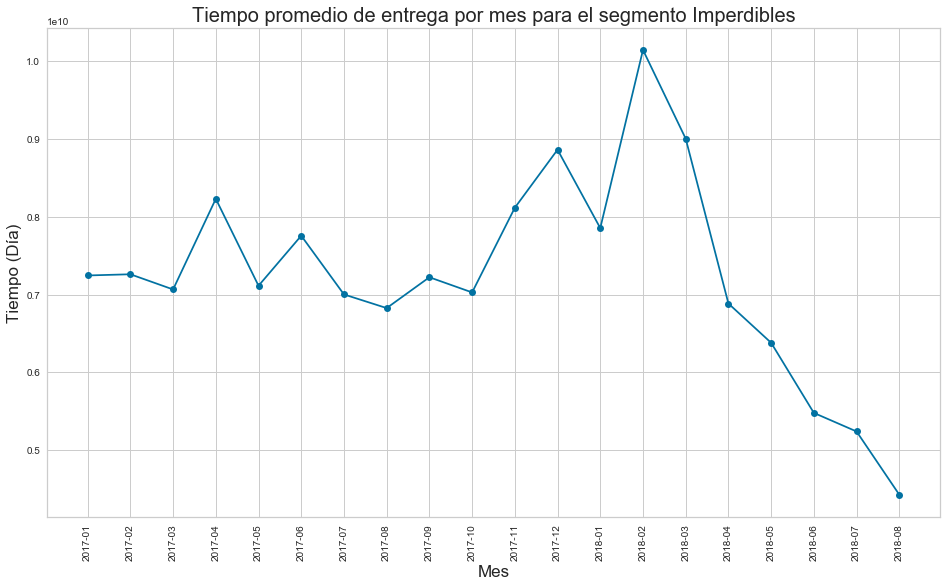

In [126]:
# ¿Cuál es el tiempo de entrega promedio Para el segmento Imperdibles?
delivery_time_by_month = all_data_rfm.loc[all_data_rfm['RFM_Level']=='Imperdibles','order_delivery_time'].groupby(all_data_rfm['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta


fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o')
plt.title('Tiempo promedio de entrega por mes para el segmento Imperdibles',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Tiempo (Día)',fontsize=17)

### Conclusión: Para el segmento imperdibles no observamos diferencia en los tiempos de entrega con respecto al promedio de todos los clientes. Las curvas son prácticamente iguales. Por lo tanto no tomaremos una acción a partir de este dato.

### Ahora analizaremos el segmento de Frizados, para averiguar sus particularidades e intentar atraerlos nuevamente

Text(0, 0.5, 'Categoría de producto')

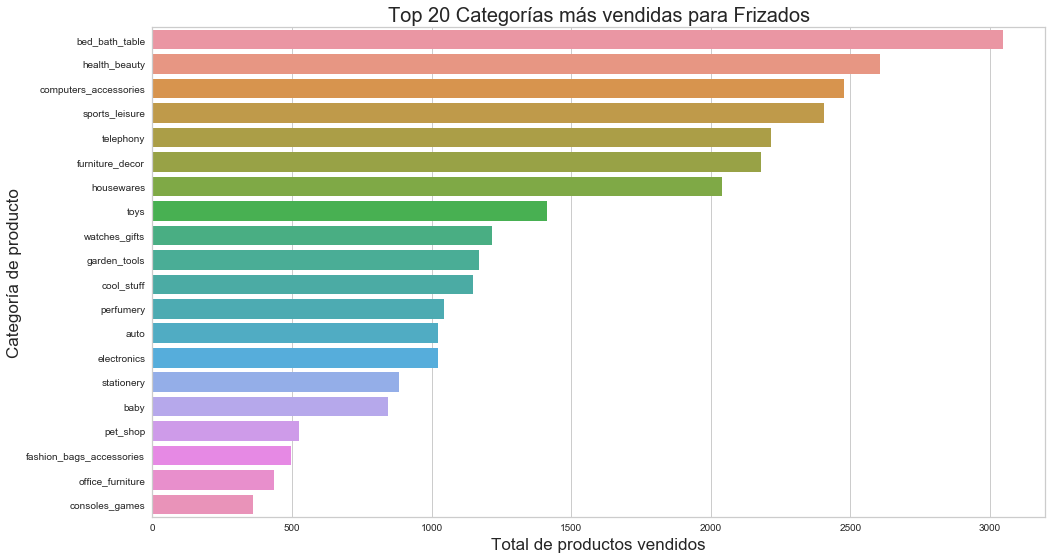

In [127]:
# ¿Qué categoría de productos tienen más demanda para el segmento Frizados??
top_20_product_best_seller = all_data_rfm.loc[all_data_rfm['RFM_Level']=='Frizados','order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]
#print(top_20_product_best_seller)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values)
plt.title('Top 20 Categorías más vendidas para Frizados',fontsize=20)
plt.xlabel('Total de productos vendidos',fontsize=17)
plt.ylabel('Categoría de producto',fontsize=17)

### Conclusión: Vemos que este segmento valora más las categorías de productos de "health_beauty" y "computer_accesories" con respecto al promedio de clientes, por lo tanto nos enfocaremos en analizar los productos de estas dos categorías antes de tomar una acción.

Text(0, 0.5, 'ID de producto')

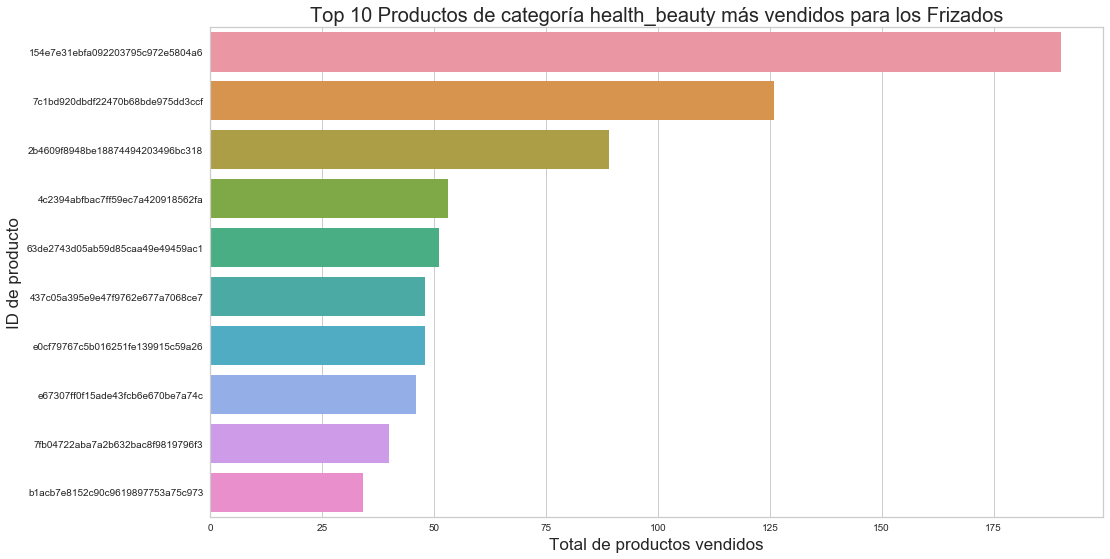

In [128]:
# ¿Qué productos de la categoría "health_beauty" tienen más demanda para el segmento Frizados?
top_10_product_best_seller = all_data_rfm.loc[(all_data_rfm['RFM_Level']=='Frizados') & (all_data_rfm['product_category_name_english']=='health_beauty'),'order_item_id'].groupby(all_data_rfm['product_id']).sum().sort_values(ascending=False)[:10]

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_product_best_seller.index,x=top_10_product_best_seller.values)
plt.title('Top 10 Productos de categoría health_beauty más vendidos para los Frizados',fontsize=20)
plt.xlabel('Total de productos vendidos',fontsize=17)
plt.ylabel('ID de producto',fontsize=17)

Text(0, 0.5, 'ID de producto')

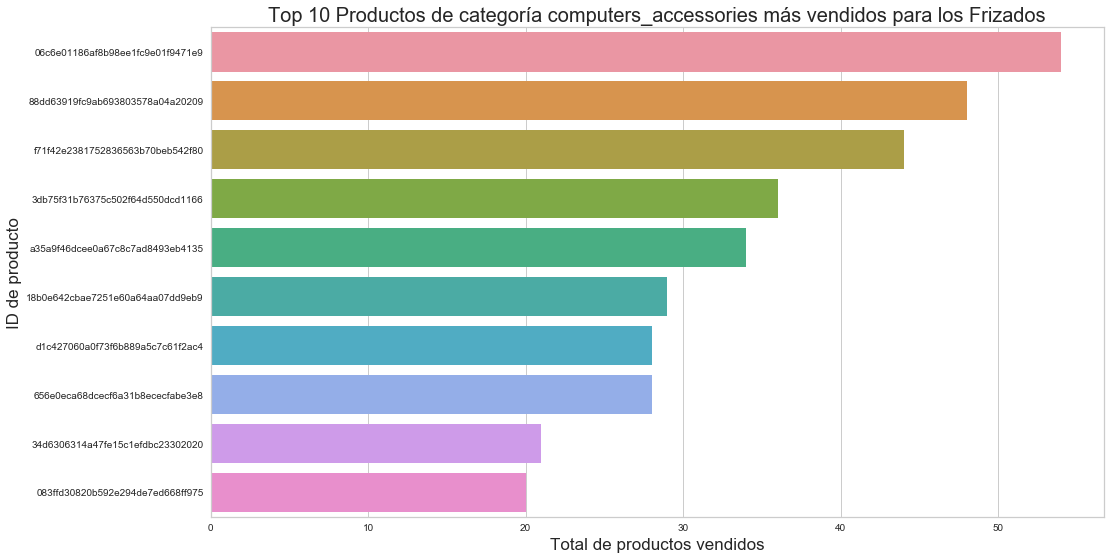

In [129]:
# ¿Qué productos de la categoría "computers_accessories" tienen más demanda para el segmento Frizados?
top_10_product_best_seller = all_data_rfm.loc[(all_data_rfm['RFM_Level']=='Frizados') & (all_data_rfm['product_category_name_english']=='computers_accessories'),'order_item_id'].groupby(all_data_rfm['product_id']).sum().sort_values(ascending=False)[:10]

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_product_best_seller.index,x=top_10_product_best_seller.values)
plt.title('Top 10 Productos de categoría computers_accessories más vendidos para los Frizados',fontsize=20)
plt.xlabel('Total de productos vendidos',fontsize=17)
plt.ylabel('ID de producto',fontsize=17)

### Acción: Tras analizar las categorías preferidas del segmento Frizados y observar cuales son los 10 productos más consumidos dentro de esas categorías tomaremos la acción de hacer una campaña de promoción masiva por e-mail ofreciendo dichos productos.